In [1]:
import pandas as pd
#import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import random
random.seed(10)

# Reading in the file

In [2]:
df_raw = pd.read_csv("data/preprocessed.csv")
df_raw.iloc[:,0:15].head()

,minplayers,maxplayers,minplaytime,maxplaytime,minage,usersrated,average,stddev,avgweight,numweights,boardgamedesigner_cnt,boardgameartist_cnt,boardgamepublisher_cnt,boardgamecategory_cnt,boardgamemechanic_cnt
0,1,4,60,120,12,31254,8.85292,1.59819,3.8078,1311,1,3,9,5,12
1,2,4,60,60,13,34729,8.62499,1.59463,2.8301,971,2,1,11,2,8
2,1,5,120,120,12,48339,8.42299,1.36938,3.2313,1863,1,1,13,6,9
3,2,4,120,120,14,18269,8.49419,1.49542,4.3850,891,1,4,13,3,5
4,2,4,60,120,14,10070,8.62031,1.22876,3.9122,467,3,3,8,3,8


# Train/Test split 
We will use a 80/20 train test split and do parametertuning using 10-fold CV

In [3]:
X = df_raw.drop(["average","usersrated","stddev","numweights"], axis=1)
y = df_raw["average"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

## Baseline

In [4]:
lin = LinearRegression()
lin.fit(X_train,y_train)
lin.score(X_train,y_train)

0.4021724528729973

## Elastic Net

In [5]:
pipeline = Pipeline([("regressor", ElasticNet(max_iter=5000))])

param_grid = {
    "regressor__alpha": [0.001,0.3,0.7,1], 
    "regressor__l1_ratio": [0.2,0.5,0.8,0.99,1]
}

grid = GridSearchCV(pipeline, param_grid, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('regressor',
                                        ElasticNet(max_iter=5000))]),
             param_grid={'regressor__alpha': [0.001, 0.3, 0.7, 1],
                         'regressor__l1_ratio': [0.2, 0.5, 0.8, 0.99, 1]})

In [6]:
r2 = grid.score(X_test, y_test)
print("Test R2 score: {:.2f}".format(r2))
r2 = grid.score(X_train, y_train)
print("Train R2 score: {:.2f}".format(r2))

Test R2 score: 0.41
Train R2 score: 0.40


In [7]:
grid.best_params_

{'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.2}

## Random Forest

In [8]:
pipeline = Pipeline([("regressor", RandomForestRegressor(100))])

param_grid = {
    "regressor__max_features": [0.1,0.2,0.4,0.6,0.8,1],
}

grid = GridSearchCV(pipeline, param_grid, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_features': [0.1, 0.2, 0.4, 0.6, 0.8,
                                                     1]})

In [9]:
grid.best_params_

{'regressor__max_features': 0.2}

In [10]:
r2 = grid.score(X_test, y_test)
print("Test R2 score: {:.3f}%".format(r2))
r2 = grid.score(X_train, y_train)
print("Train R2 score: {:.3f}%".format(r2))

Test R2 score: 0.47%
Train R2 score: 0.92%


### Feature importance

When looking at the feature importance, avgweight seems to have the biggest impact by far. 

<AxesSubplot: >

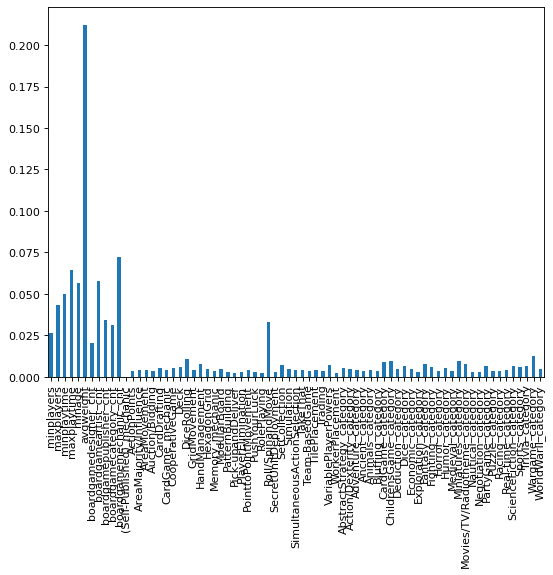

In [13]:
plt.figure(figsize=(8, 6), dpi=80)
forest_importances = pd.Series(grid.best_estimator_.named_steps["regressor"].feature_importances_, index=X_train.columns)
forest_importances.plot.bar()

In [40]:
#s0 = grid.cv_results_["split0_test_score"]
#tmp = pd.DataFrame({'0.1':s0[0],'0.2':s0[1],'0.4':s0[2],'0.6':s0[3],'0.8':s0[4],'1':s0[0]})
#pd.concat(tmp,grid.cv_results_["split0_test_score"])
#tmp.iloc[0,:]
grid.cv_results_

{'mean_fit_time': array([ 4.3040632 ,  7.955597  , 11.16715662, 11.87688389, 14.77036324,
         3.17643058]),
 'std_fit_time': array([0.88404701, 1.48572886, 2.80096789, 1.54374205, 2.03157181,
        0.92273104]),
 'mean_score_time': array([0.08207784, 0.08851078, 0.07995968, 0.05944507, 0.06019573,
        0.08384829]),
 'std_score_time': array([0.03896389, 0.03509217, 0.02259752, 0.00677372, 0.0136369 ,
        0.04124613]),
 'param_regressor__max_features': masked_array(data=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'regressor__max_features': 0.1},
  {'regressor__max_features': 0.2},
  {'regressor__max_features': 0.4},
  {'regressor__max_features': 0.6},
  {'regressor__max_features': 0.8},
  {'regressor__max_features': 1}],
 'split0_test_score': array([0.47650172, 0.48218019, 0.47067662, 0.47085199, 0.46350939,
        0.44756698]),
 'split1_test_score': array([0.

# Testing on the full training set

Document performance of the final model. Since we used CV we don't  have a final model. We will use the scores given by the mean and the best fold.

In [45]:
print("R2 score averaged across all folds:",round(grid.cv_results_['mean_test_score'][2],3))
print("R2 score of best fold:",round(grid.cv_results_['split9_test_score'][2],3))

R2 score averaged across all folds: 0.454
R2 score of best fold: 0.466


GridSearchCV automatically refits on the whole data set.
The refit is better than the average of all folds and performs about the same as the best fold. This is expected as we already use a small validation set (10% of the training set) 

In [39]:
forest = RandomForestRegressor(max_features= 0.2)
forest.fit(X_train,y_train)
forest.score(X_test,y_test)

0.4699272432761955

## Testing on a subspace of the data

In [46]:
counter = 2793
percentage = (df_raw.loc[:,"usersrated"] >= counter).sum()/20000 
print("{}% of {} is over {}".format(round(100*percentage,1),"usersrated",counter))

5.0% of usersrated is over 2793


Testing the top 5% and bottom 95% of "usersrated" (amount of ratings per game)

### Forest

In [56]:
print('R2 for top 5% of "usersrated": {}'.format(forest.score(X_test[df_raw.iloc[X_test.index,5] >= 2793], y_test[df_raw.iloc[X_test.index,5] >= 2793])))
print('R2 for bottom %95 of "usersrated": {}'.format(forest.score(X_test[df_raw.iloc[X_test.index,5] < 2793], y_test[df_raw.iloc[X_test.index,5] < 2793])))

R2 for top 5% of "usersrated": 0.395672645874941
R2 for bottom %95 of "usersrated": 0.44585374666619215


### Baseline

In [57]:
print('R2 for top 5% of "usersrated": {}'.format(lin.score(X_test[df_raw.iloc[X_test.index,5] >= 2793], y_test[df_raw.iloc[X_test.index,5] >= 2793])))
print('R2 for bottom %95 of "usersrated": {}'.format(lin.score(X_test[df_raw.iloc[X_test.index,5] < 2793], y_test[df_raw.iloc[X_test.index,5] < 2793])))

R2 for top 5% of "usersrated": 0.2569338035171551
R2 for bottom %95 of "usersrated": 0.38861469543961125
